Variational Autoencoder test

Python version: 3.12.0 <br>
PyTorch version: 2.5.0 <br>
Numpy version: 2.1.0 <br>

In [9]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

image_size = (16, 16)
image_vector_dim = image_size[0] * image_size[1]

object_size = (7, 7)

input_dimension = image_size[0] * image_size[1]
hidden_dimension_encoder = 20
latent_dimension = 2
hidden_dimension_decoder = 20

output_dimension = image_size[0] * image_size[1]

seed = 12321
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

dataset_size = 5000
batch_size = 20
epochs = 50
learning_rate = 0.002

cuda


In [10]:
from typing import Tuple
import matplotlib.pyplot as plt
from enum import Enum

class ObjectDataset(Dataset):
    def __init__(self, dataset_size, image_size, object_size):
        self.dataset_size = dataset_size
        self.image_size = image_size
        self.object_size = object_size
        self.object = torch.rand(self.object_size)

        self.object_x_min = 0
        self.object_x_max = self.image_size[0] - self.object_size[0]
        self.object_y_min = 0
        self.object_y_max = self.image_size[0] - self.object_size[0]
    
    def __len__(self) -> int:
        return self.dataset_size

    def __getitem__(self, idx: int):
        z = torch.zeros(self.image_size)
        
        object_x = np.random.randint(self.object_x_min, self.object_x_max + 1)
        object_y = np.random.randint(self.object_y_min, self.object_y_max + 1)
        
        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = self.object        
        return z

class DiagonalObjectDataset(ObjectDataset):
    def __init__(self, dataset_size, image_size, object_size):
        super(DiagonalObjectDataset,self).__init__(dataset_size, image_size, object_size)

    def __getitem__(self, idx: int):          
        z = torch.zeros(self.image_size)
        step_x = self.object_x_max / (self.dataset_size - 1)
        step_y = self.object_y_max / (self.dataset_size - 1)

        object_x = step_x * idx
        object_y = step_y * idx
        
        object_x = int(object_x)
        object_y = int(object_y)
        
        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = self.object        
        return z

class CornerObjectDataset(ObjectDataset):
    class Mode(Enum):
        top_left     = 0
        bottom_right = 1
        
    def __init__(self, dataset_size, image_size, object_size, mode):
        super(CornerObjectDataset,self).__init__(dataset_size, image_size, object_size)
        self.mode = mode

    def __getitem__(self, idx: int):          
        z = torch.zeros(self.image_size)

        object_x = 0
        object_y = 0
        
        if self.mode == CornerObjectDataset.Mode.bottom_right:
            object_x = self.object_x_max
            object_y = self.object_y_max

        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = self.object 
        return z

dataset_training = ObjectDataset(dataset_size=dataset_size, image_size=image_size, object_size=object_size)
dataset_testing = ObjectDataset(dataset_size=batch_size*4, image_size=image_size, object_size=object_size)
dataset_diagonal = DiagonalObjectDataset(dataset_size=2, image_size=image_size, object_size=object_size)

dataset_tl_corner = CornerObjectDataset(dataset_size=1, image_size=image_size, object_size=object_size, mode=CornerObjectDataset.Mode.top_left)
dataset_br_corner = CornerObjectDataset(dataset_size=1, image_size=image_size, object_size=object_size, mode=CornerObjectDataset.Mode.bottom_right)

dataloader_training = DataLoader(dataset_training, batch_size=batch_size)
dataloader_testing = DataLoader(dataset_testing, batch_size=batch_size)
dataloader_diagonal = DataLoader(dataset_diagonal, batch_size=2)

dataloader_tl = DataLoader(dataset_tl_corner, batch_size=1)
dataloader_br = DataLoader(dataset_br_corner, batch_size=1)

In [11]:
# Encoder
class StandardEncoder(torch.nn.Module):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(StandardEncoder, self).__init__()
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.latent_dimension = latent_dimension

        self.fc0 = torch.nn.Linear(input_dimension, hidden_dimension)
        self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        
        self.lat = torch.nn.Linear(hidden_dimension, latent_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):        
        t = self.fc0(data)
        t = self.lrelu(t)
        t = self.fc1(t)
        t = self.lrelu(t)
        lat = self.lat(t)
        
        return lat


class VariationalEncoder(StandardEncoder):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(VariationalEncoder, self).__init__(input_dimension=input_dimension, hidden_dimension=hidden_dimension, latent_dimension=latent_dimension)

        self.var = torch.nn.Linear(hidden_dimension, latent_dimension)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        t = self.fc1(t)
        t = self.lrelu(t)

        mean = self.lat(t)
        var = self.var(t)

        return mean, var


In [12]:
# Decoder

class Decoder(torch.nn.Module):
    def __init__(self, latent_dimension, hidden_dimension, output_dimension):
        super(Decoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

        self.fc0 = torch.nn.Linear(latent_dimension, hidden_dimension)
        self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        
        self.output = torch.nn.Linear(hidden_dimension, output_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        t = self.fc1(t)
        t = self.lrelu(t)
        
        t = torch.sigmoid(self.output(t))

        return t
    

In [13]:
# Create the model and train
from torch.optim import Adam


class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

        
    def forward(self, data):
        mean, var = self.encoder(data)
        e = torch.randn_like(var).to(DEVICE)
        
        latent = mean + torch.exp(0.5 * var) * e
        
        data_ = self.decoder(latent)

        return data_, mean, var, latent

    def get_decoder(self):
        return self.decoder
        
class StandardAutoencoder(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(StandardAutoencoder, self).__init__()
        self.encoder = StandardEncoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

    def forward(self, data):
        lat = self.encoder(data)
        data_ = self.decoder(lat)

        return data_, lat
        
    def get_decoder(self):
        return self.decoder
        
vae = VariationalAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)
sae = StandardAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)

vae.to(DEVICE)
sae.to(DEVICE)

def vae_loss(data, data_, mean, var):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    KLD = -0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())
    return loss + KLD, loss, KLD

def sae_loss(data, data_):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    return loss

optimizer_vae = Adam(vae.parameters(), lr = learning_rate)
optimizer_sae = Adam(sae.parameters(), lr = learning_rate)

vae.train()
sae.train()

for e in range(epochs):
    epoch_loss_vae = 0
    epoch_kld = 0
    epoch_loss_sae = 0
    
    for data in dataloader_training:        
        data = data.view(batch_size, image_vector_dim)
        data = data.to(DEVICE)

        optimizer_vae.zero_grad()
        optimizer_sae.zero_grad()

        data_vae, mean, var, lat_vae = vae(data)
        data_sae, lat_sae            = sae(data)
        
        loss_vae,_,kld = vae_loss(data, data_vae, mean, var)
        loss_sae = sae_loss(data, data_sae)
        
        epoch_loss_vae += loss_vae.item()        
        epoch_loss_sae += loss_sae.item()
    
        loss_vae.backward()
        loss_sae.backward()
        optimizer_vae.step()
        optimizer_sae.step()
    print("Epoch",e," loss_vae:", epoch_loss_vae / dataset_size," loss_sae:", epoch_loss_sae / dataset_size)

Epoch 0  loss_vae: 92.43135139160157  loss_sae: 86.1495359375
Epoch 1  loss_vae: 70.06414230957031  loss_sae: 59.360253857421874
Epoch 2  loss_vae: 56.23610446777344  loss_sae: 53.07794946289062
Epoch 3  loss_vae: 51.07828179931641  loss_sae: 47.771189624023435
Epoch 4  loss_vae: 48.52807474365235  loss_sae: 44.96696639404297
Epoch 5  loss_vae: 47.03782038574219  loss_sae: 43.528910302734374
Epoch 6  loss_vae: 46.24799853515625  loss_sae: 42.40323588867187
Epoch 7  loss_vae: 45.6453998046875  loss_sae: 41.57871046142578
Epoch 8  loss_vae: 45.18145219726563  loss_sae: 40.75881594238281
Epoch 9  loss_vae: 44.80036296386719  loss_sae: 40.13842963867187
Epoch 10  loss_vae: 44.377444458007815  loss_sae: 39.58535594482422
Epoch 11  loss_vae: 44.01682708740234  loss_sae: 39.083821630859376
Epoch 12  loss_vae: 43.74686209716797  loss_sae: 38.60066469726563
Epoch 13  loss_vae: 43.355393737792966  loss_sae: 38.146644689941404
Epoch 14  loss_vae: 43.05950415039062  loss_sae: 37.80118717041016
Epo

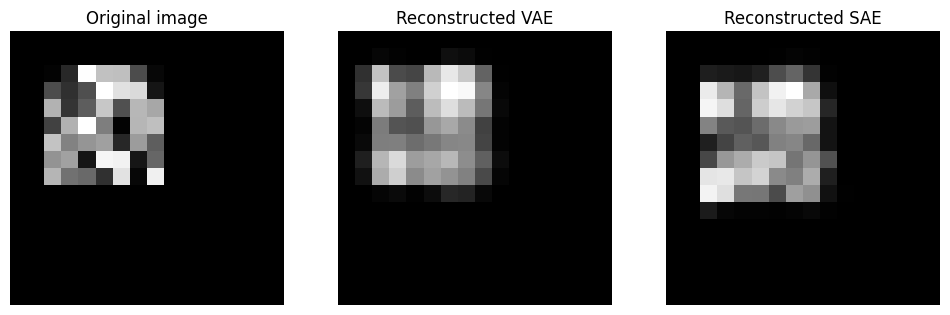

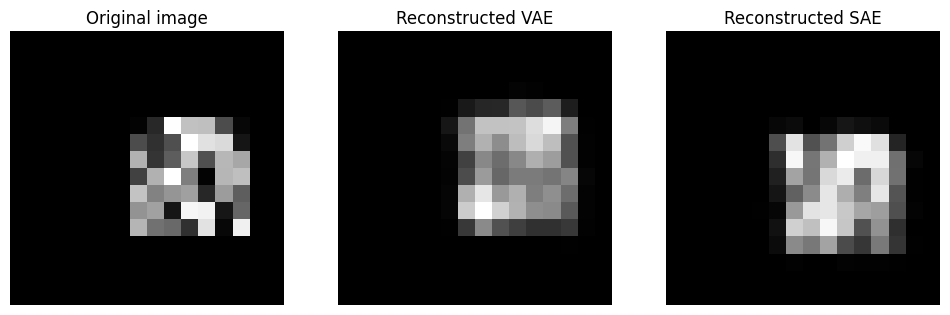

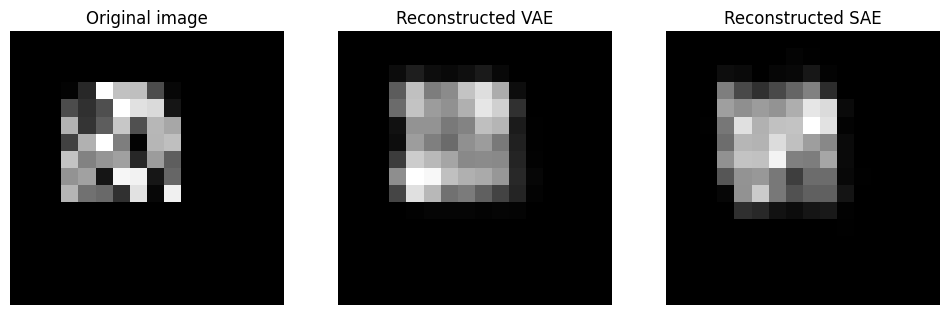

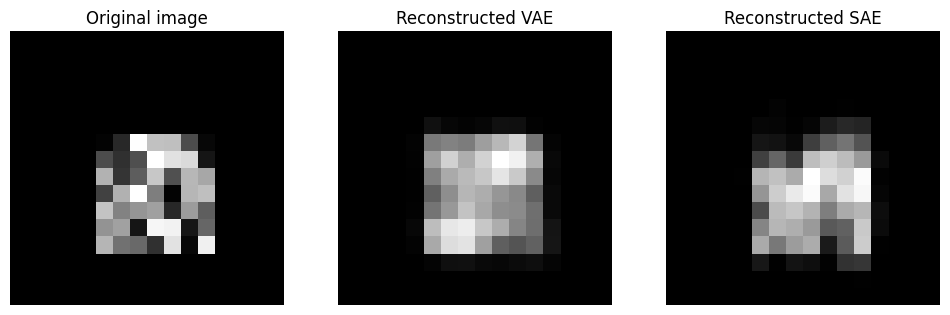

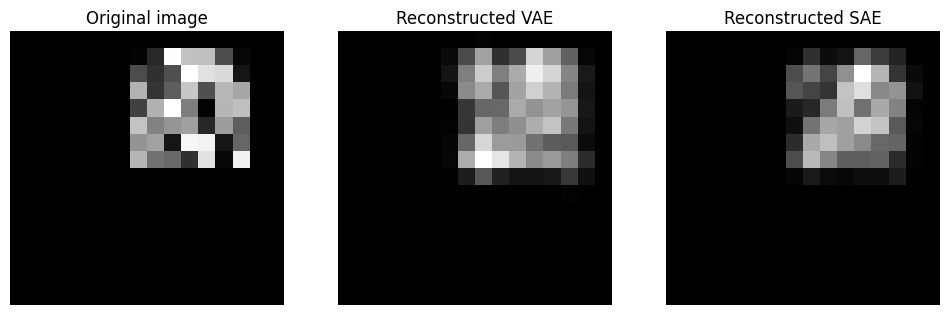

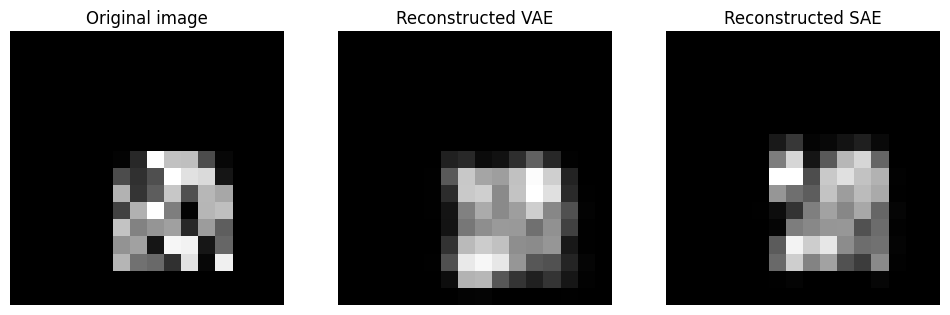

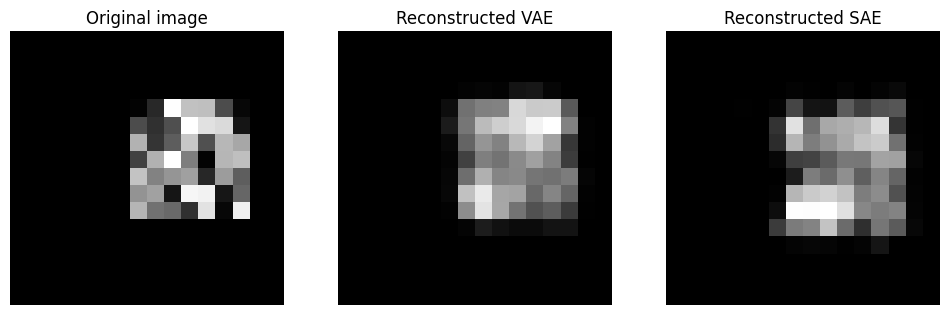

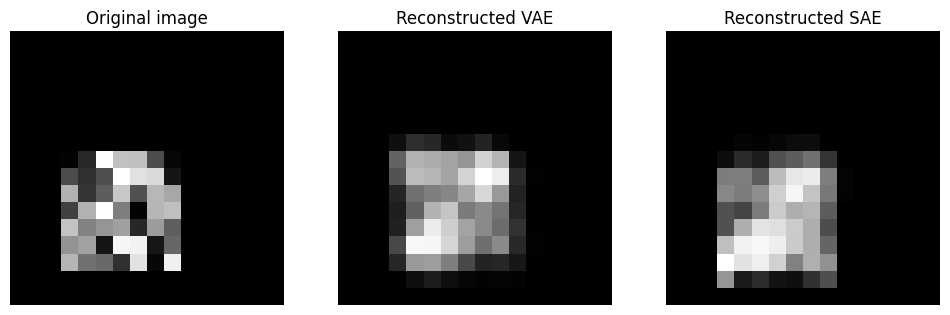

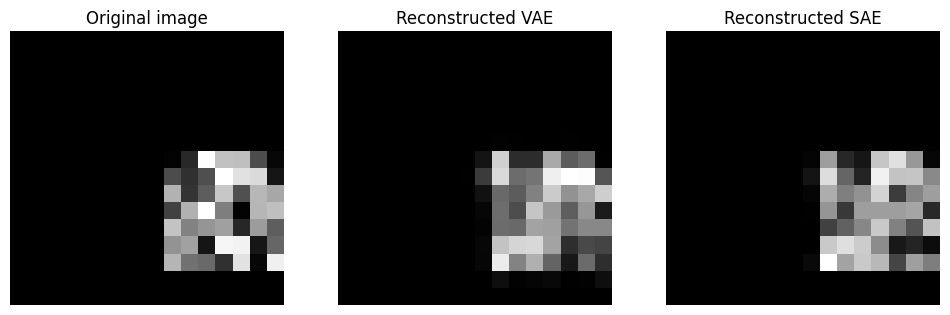

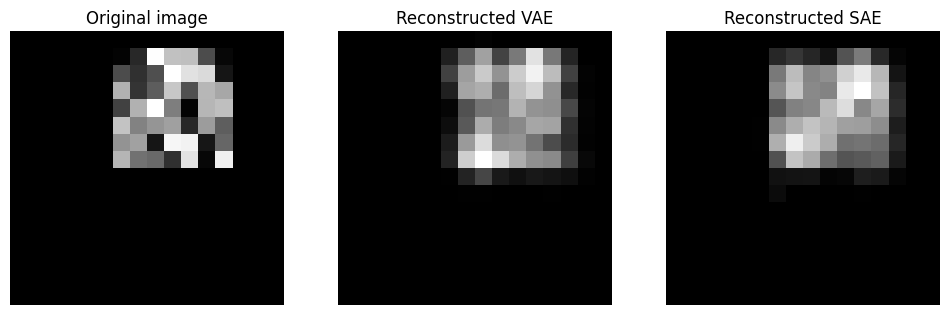

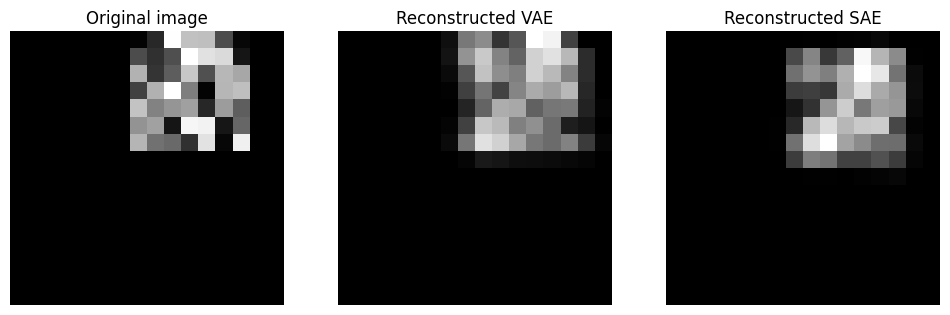

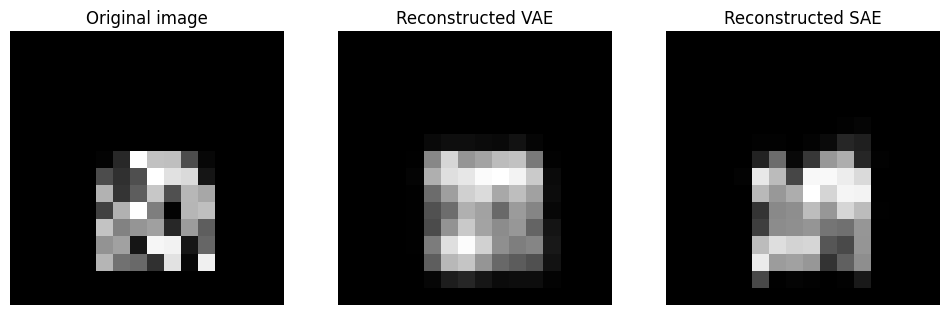

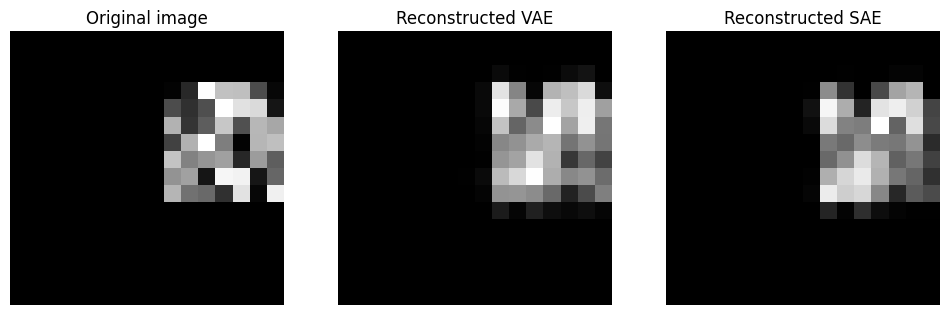

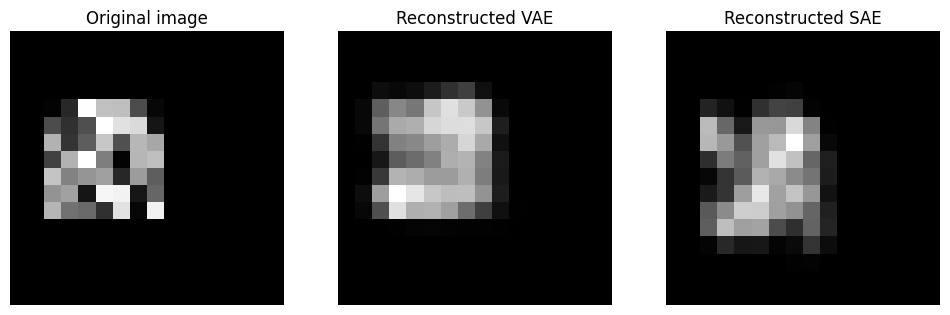

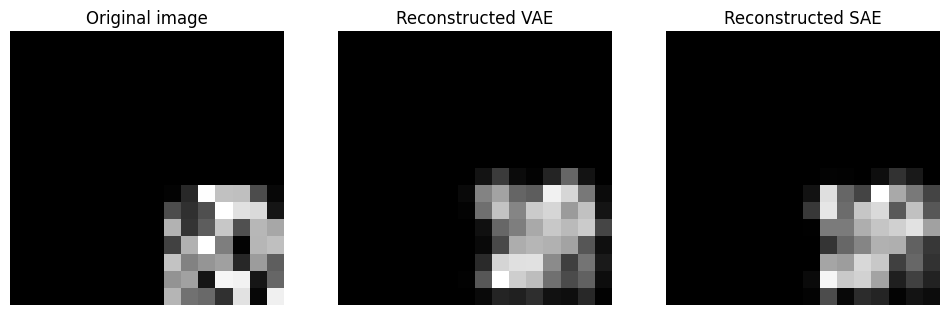

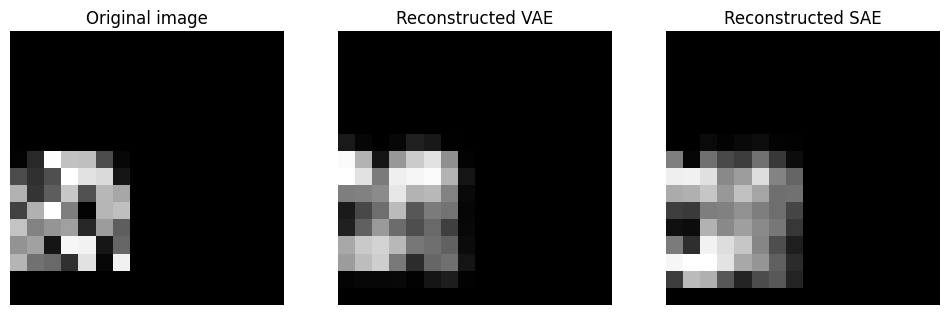

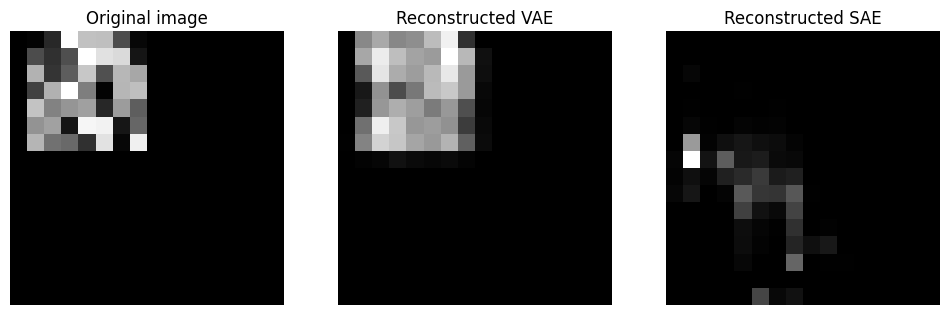

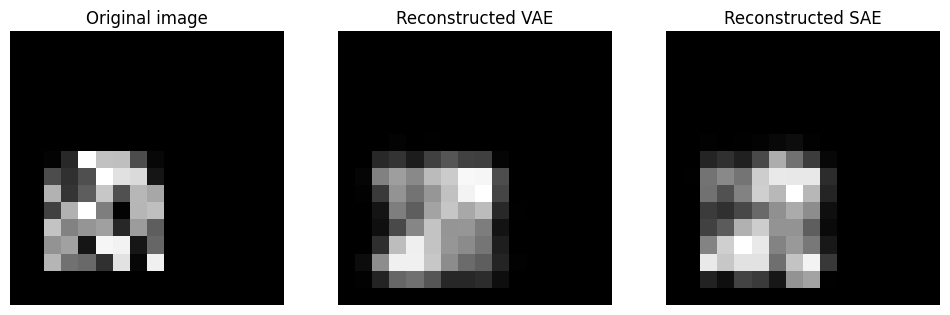

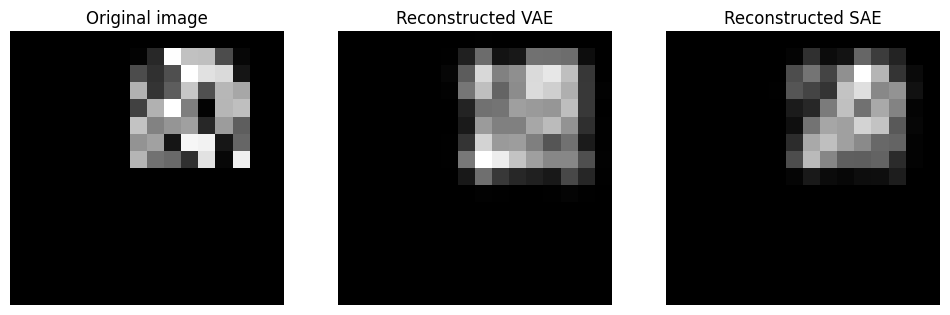

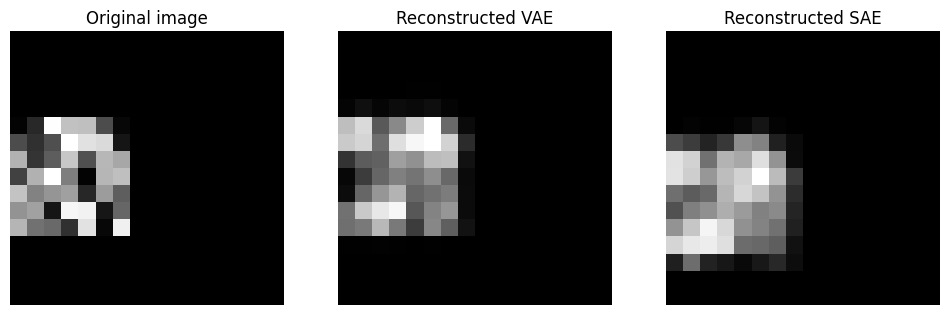

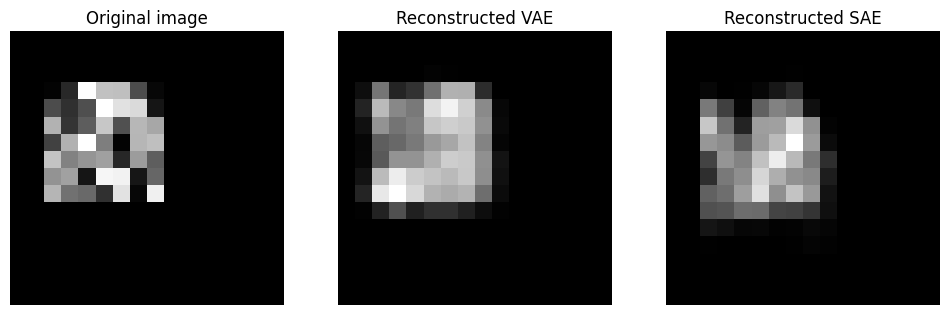

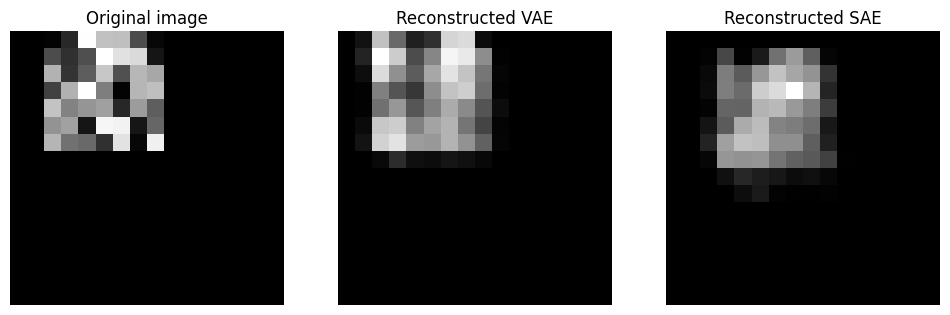

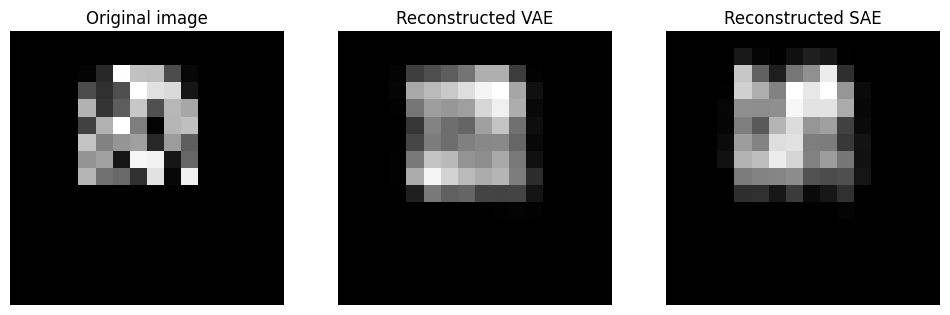

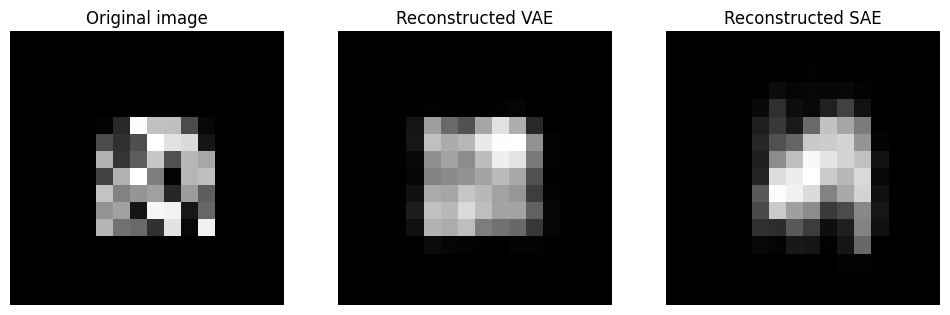

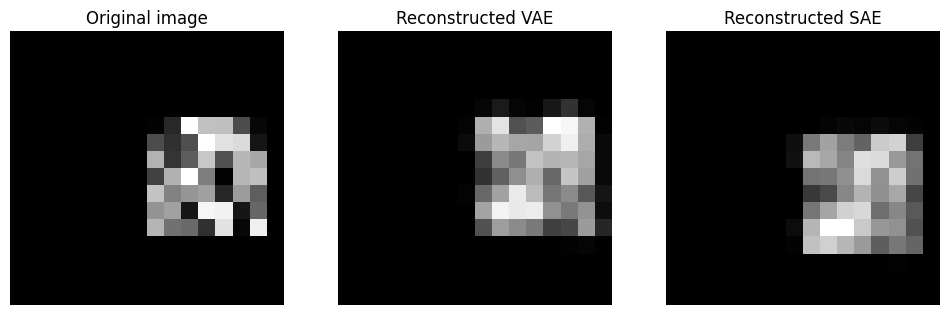

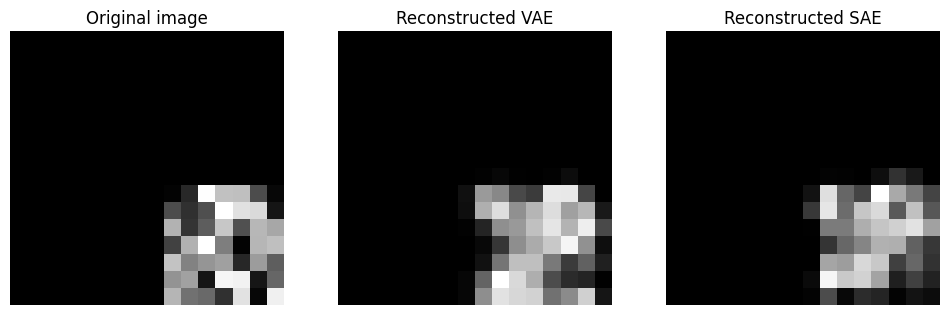

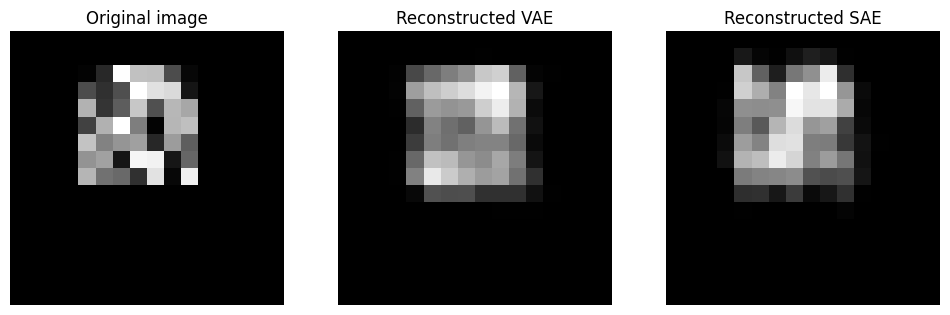

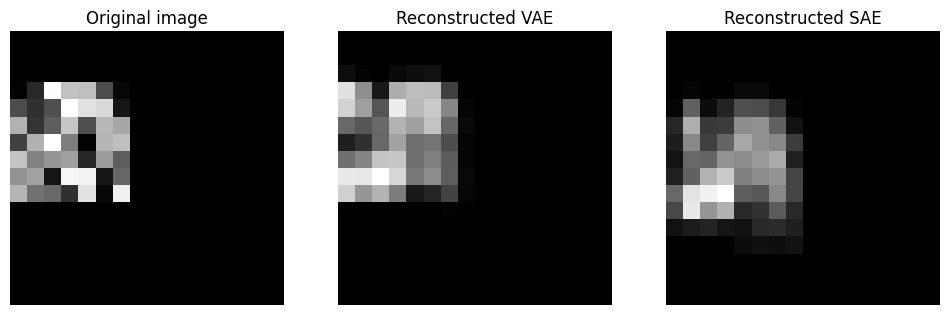

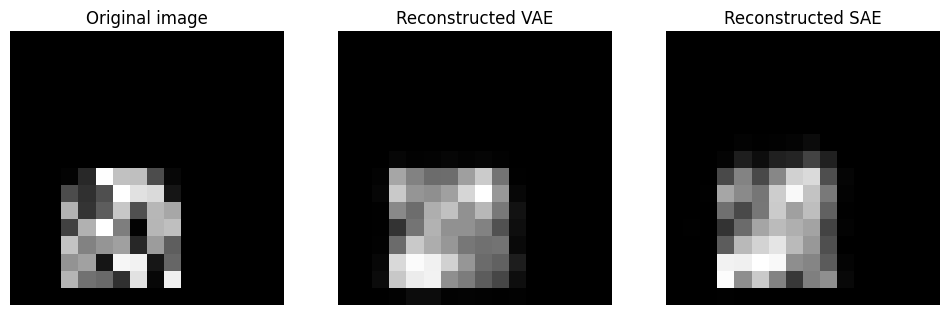

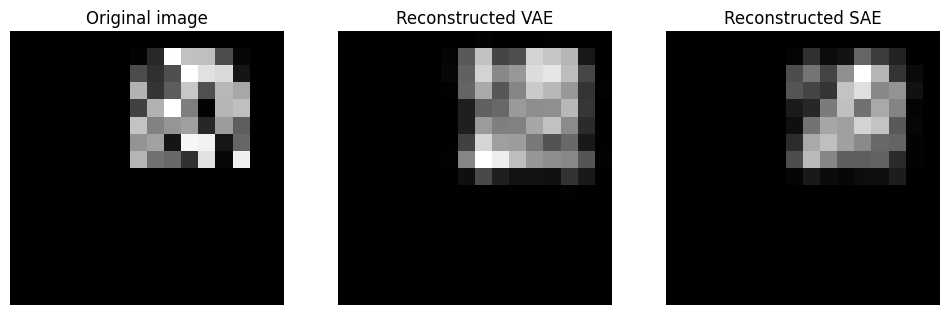

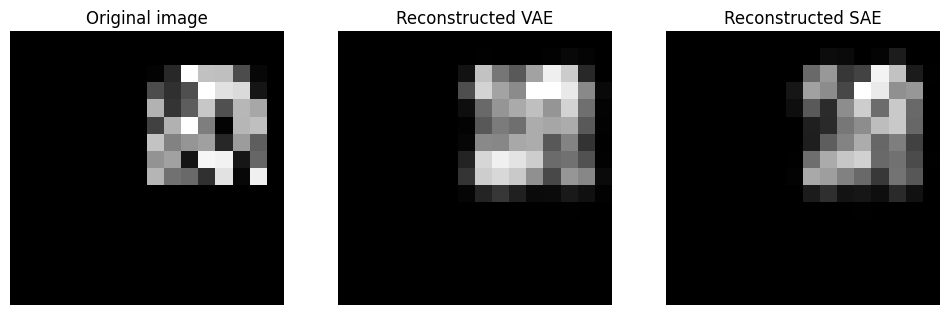

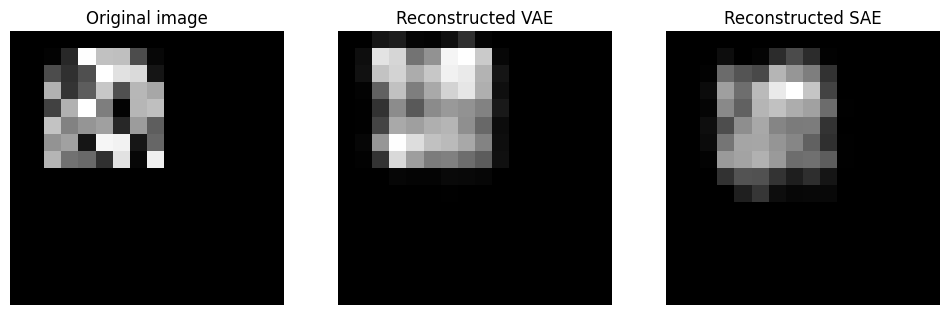

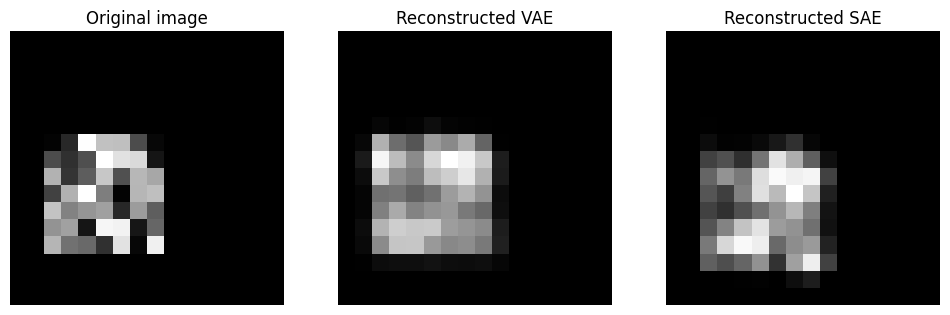

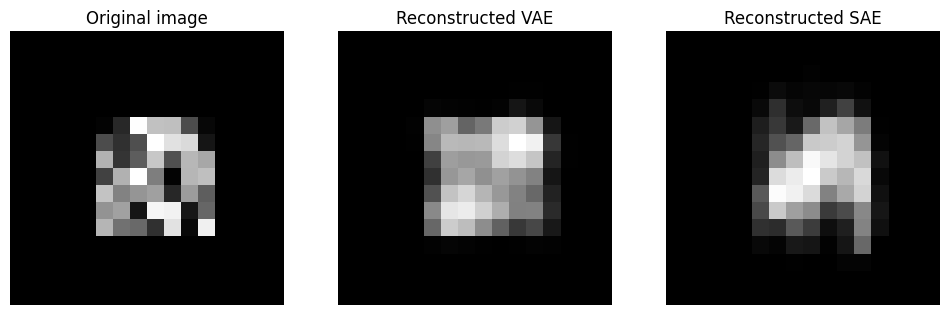

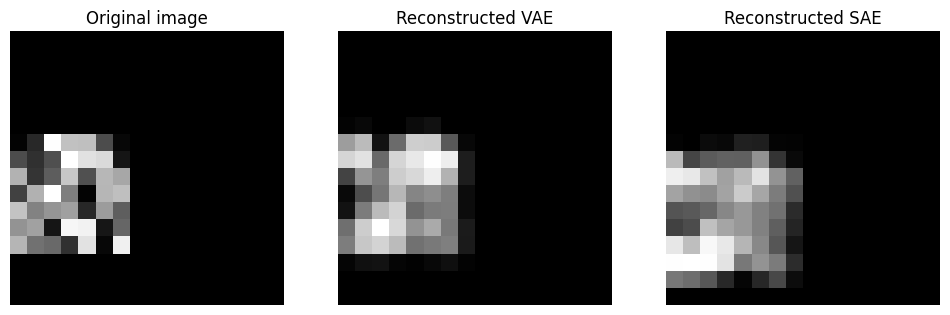

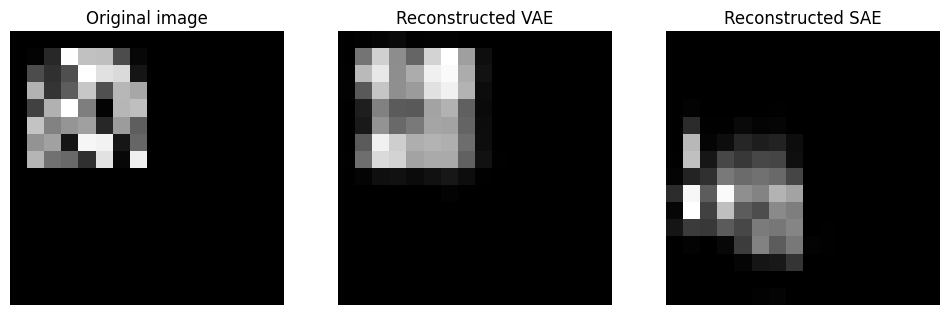

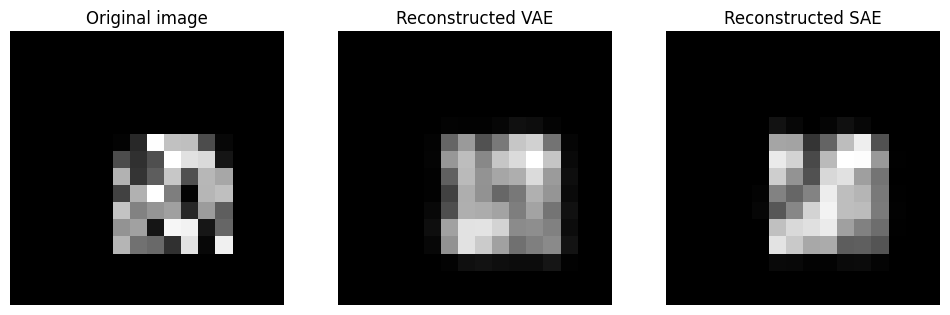

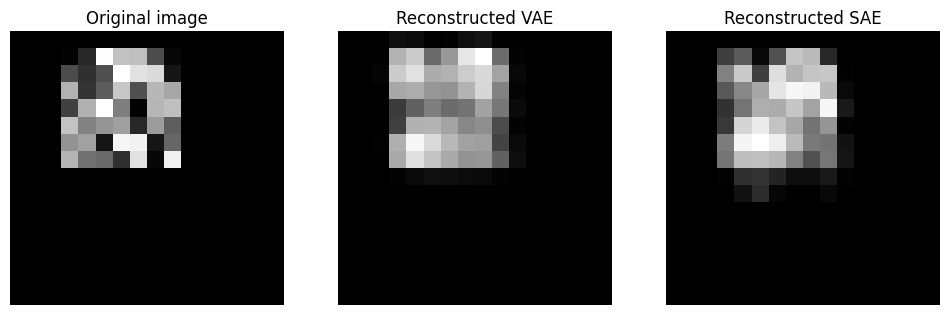

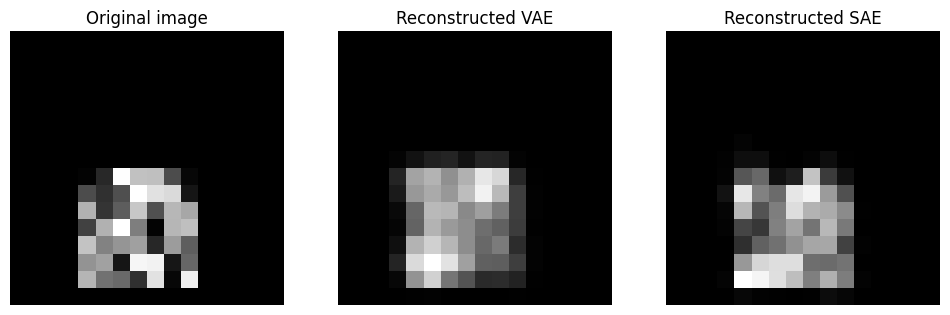

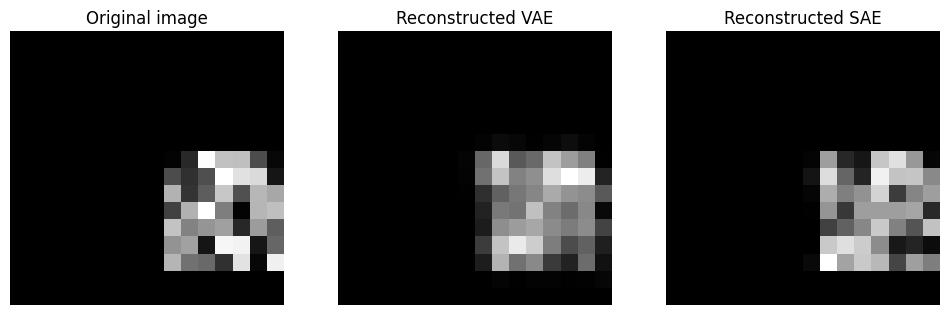

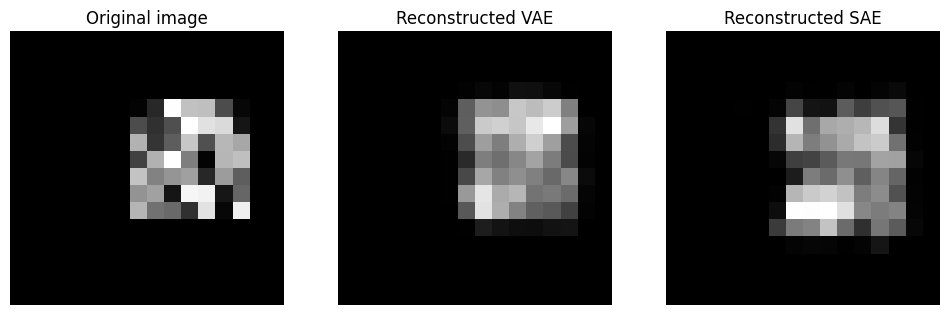

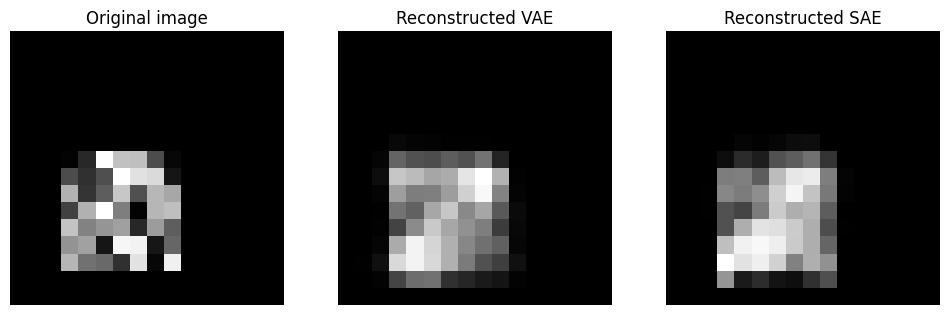

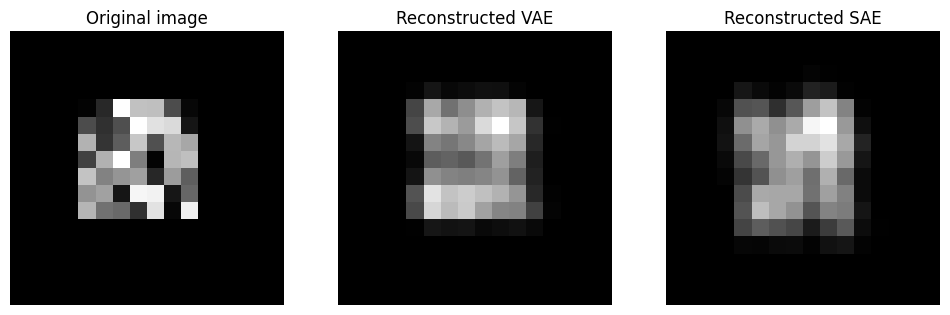

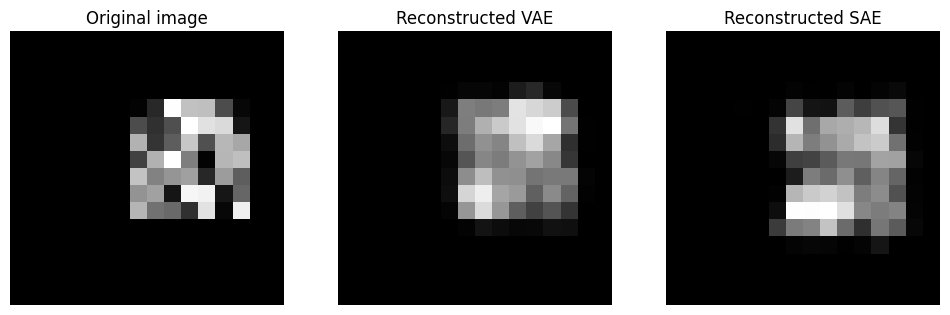

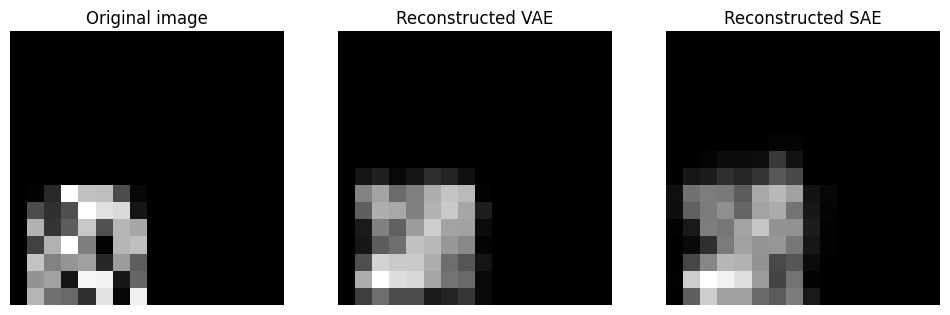

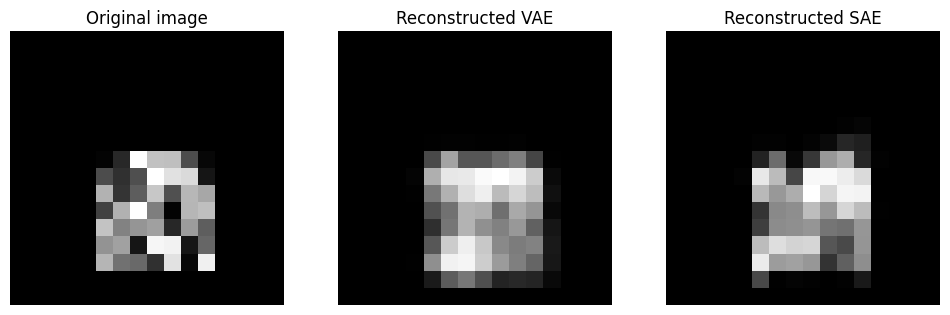

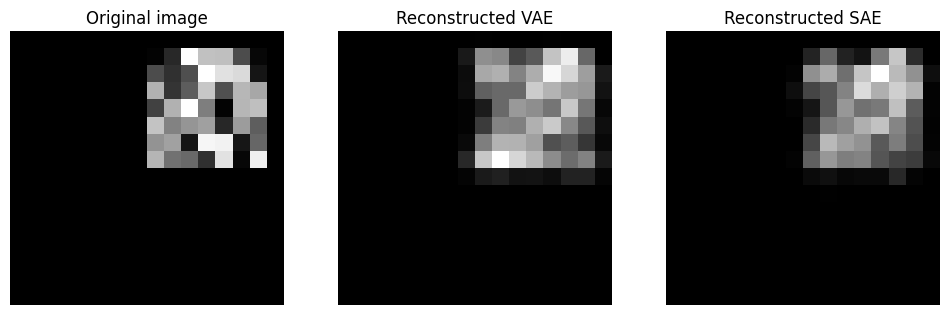

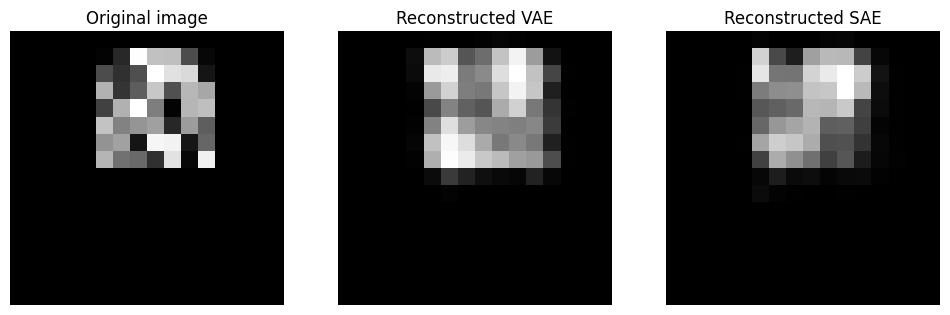

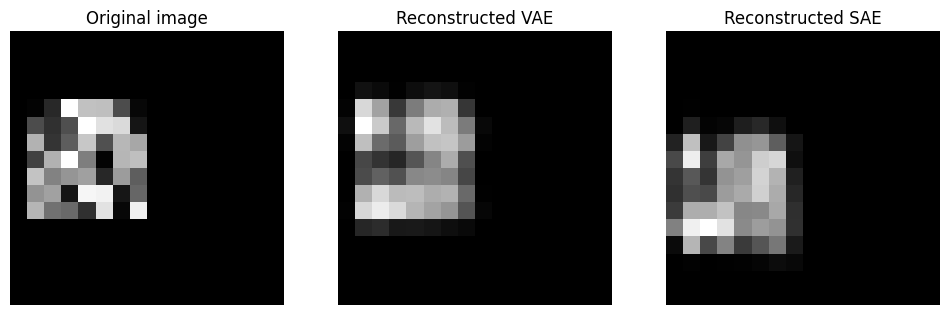

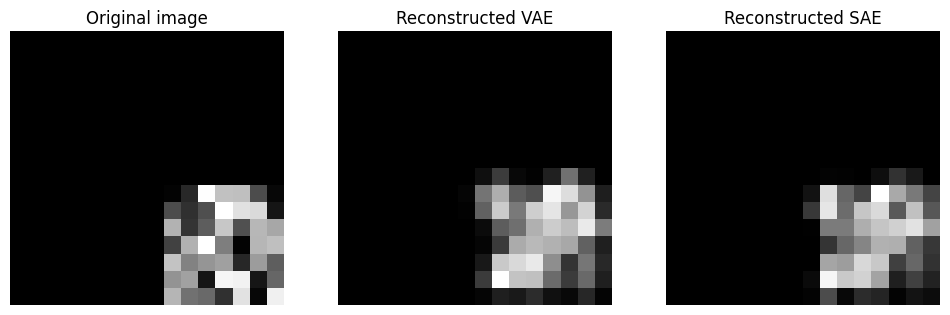

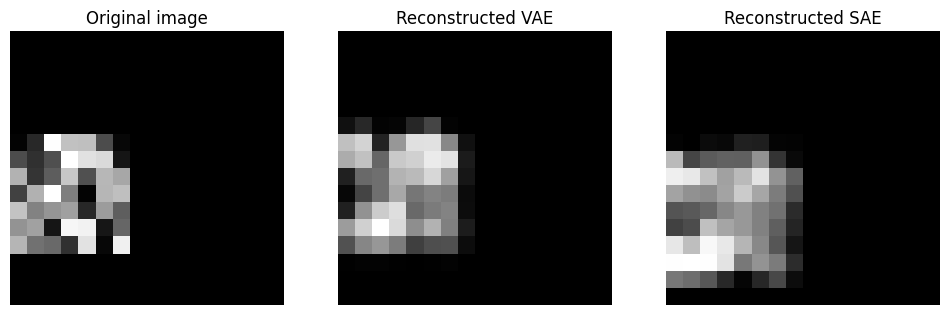

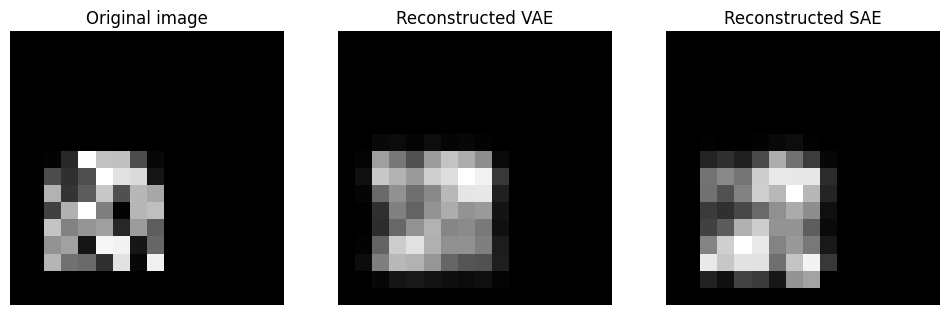

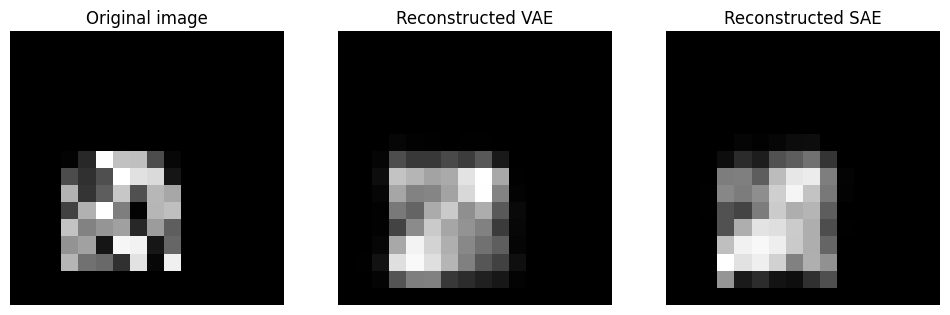

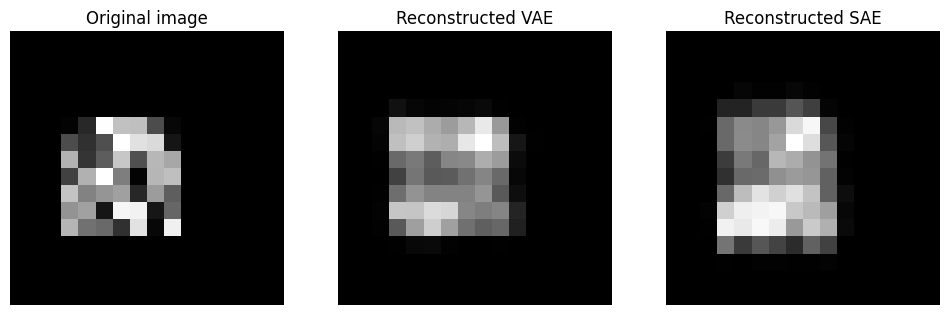

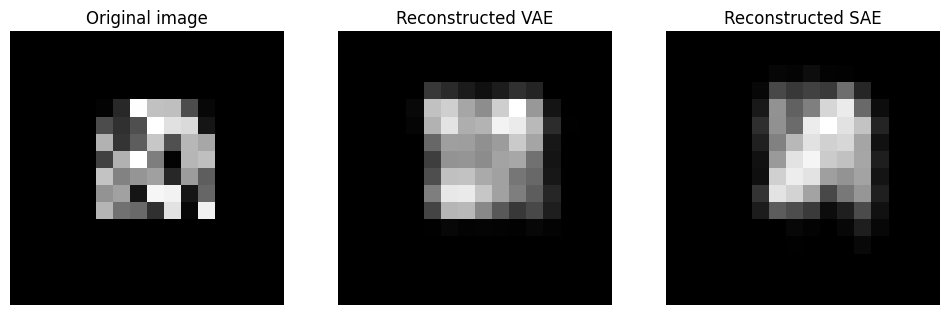

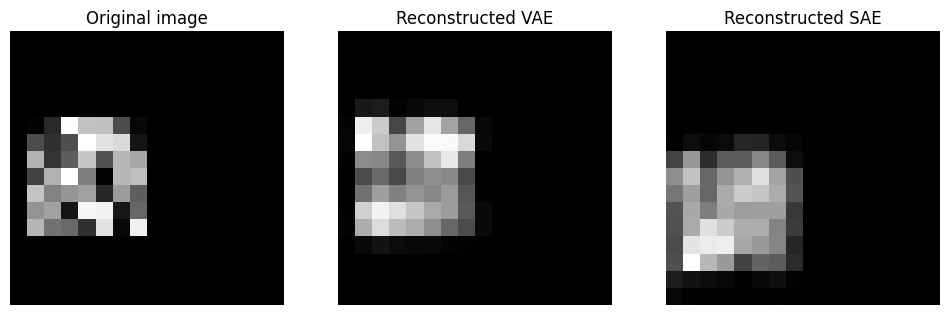

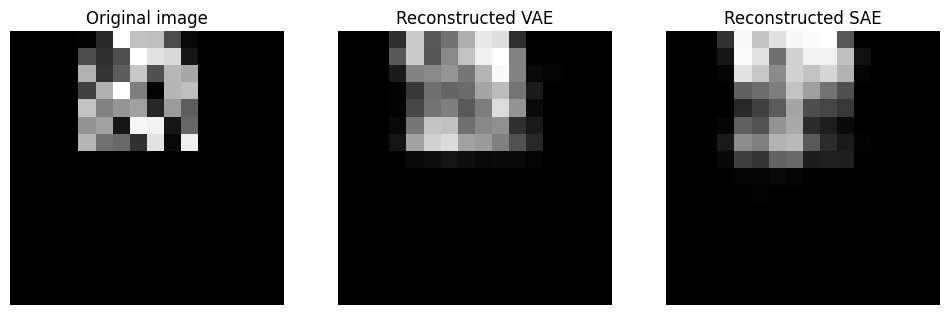

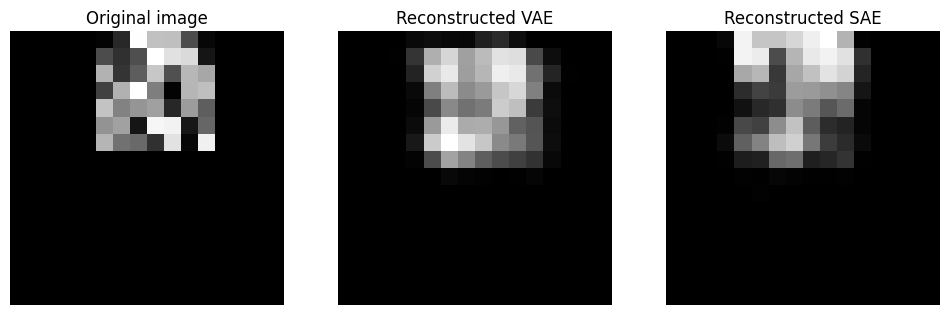

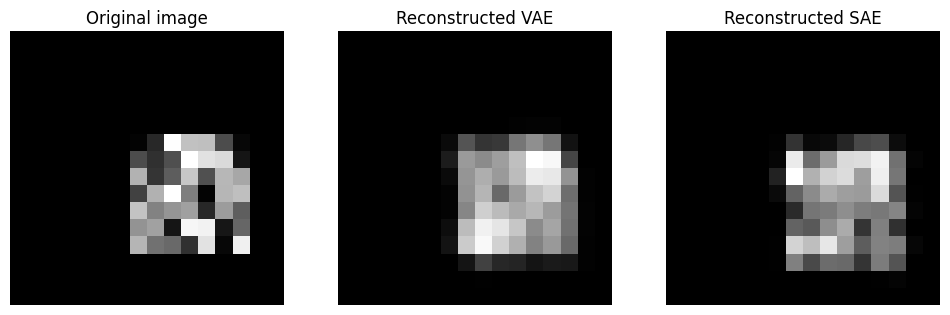

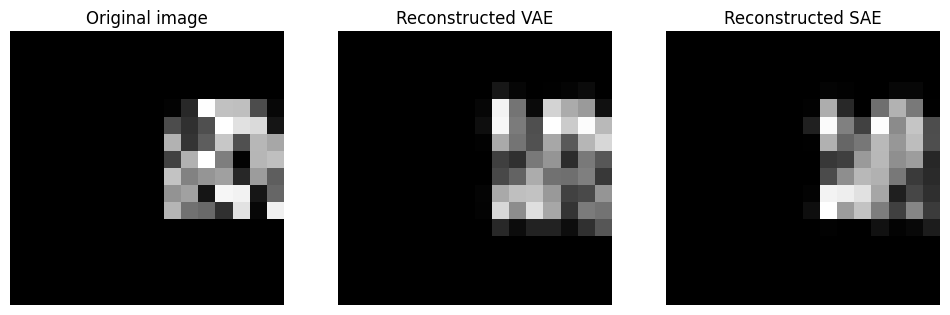

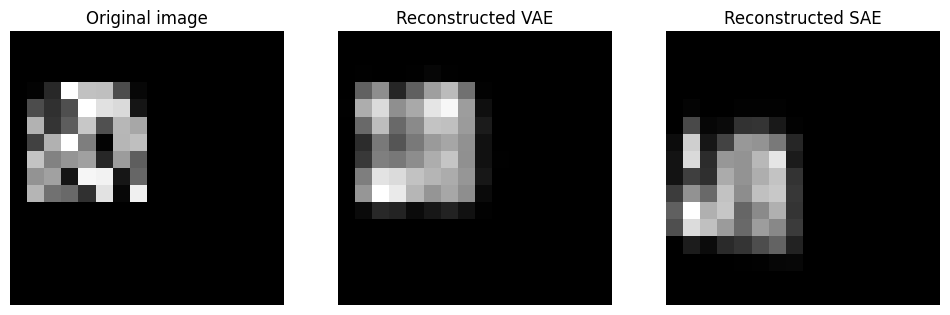

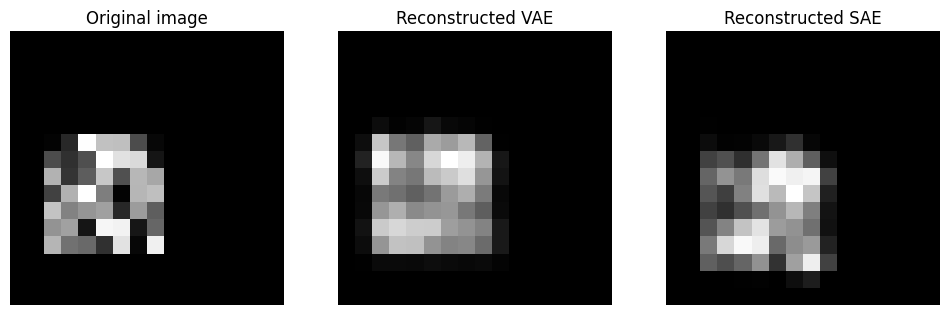

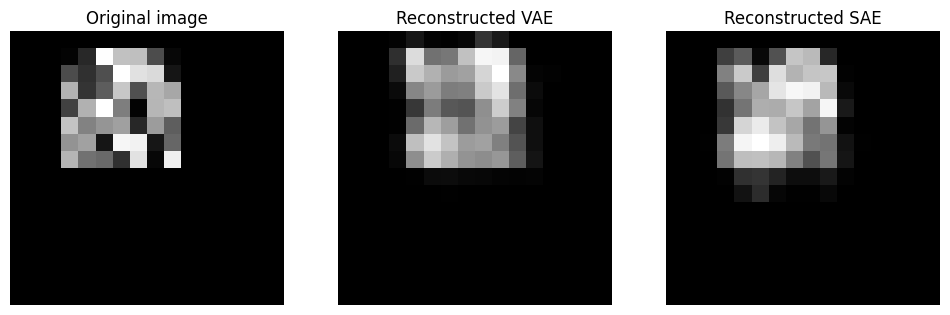

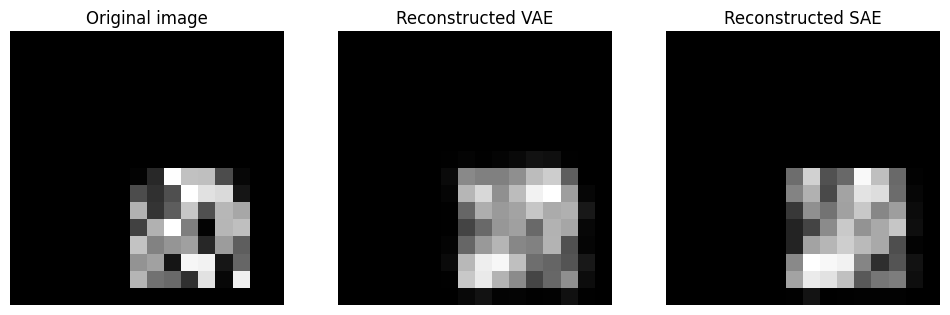

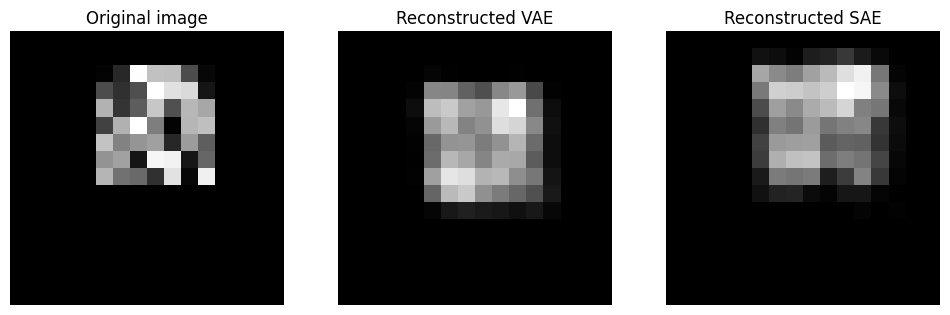

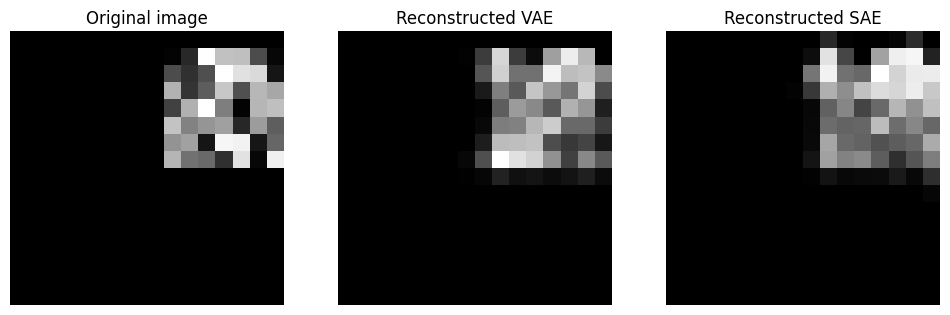

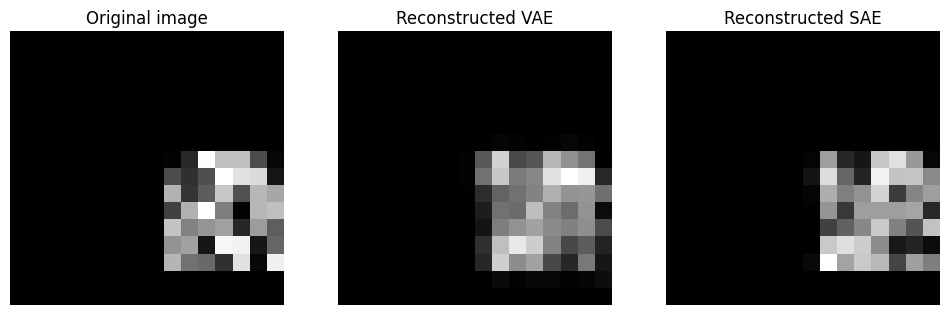

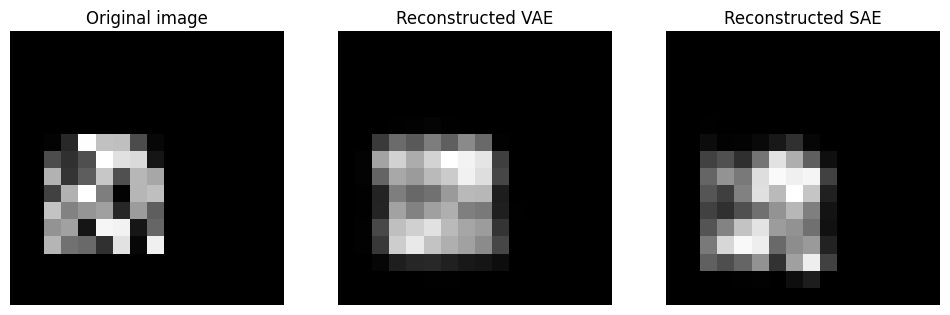

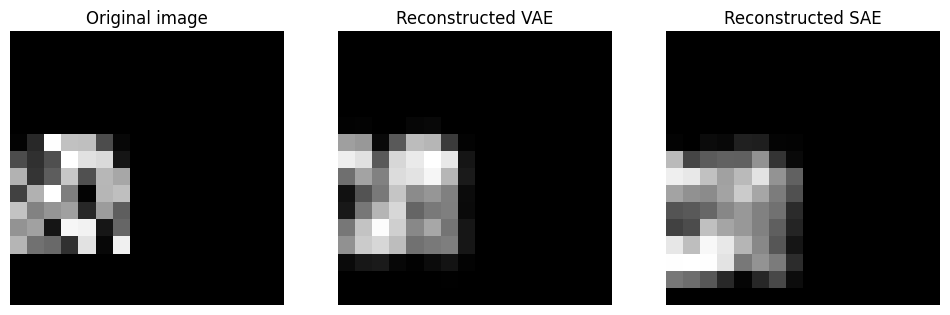

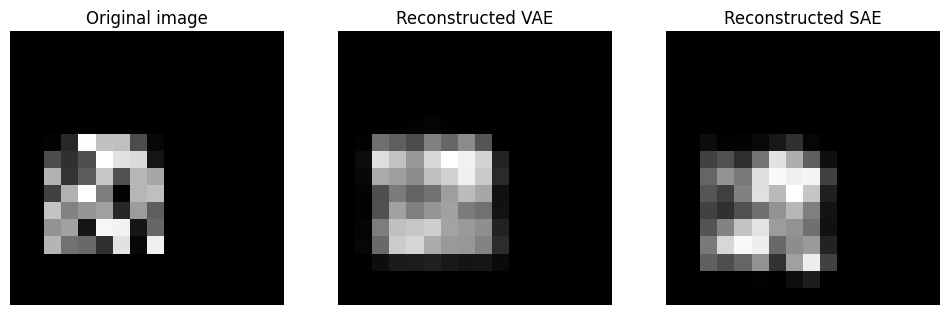

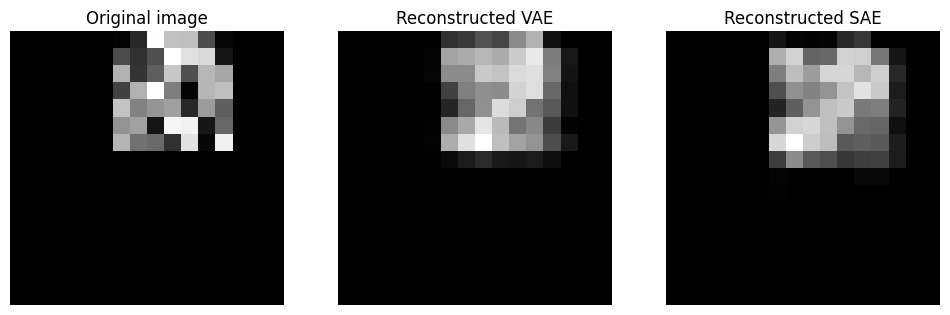

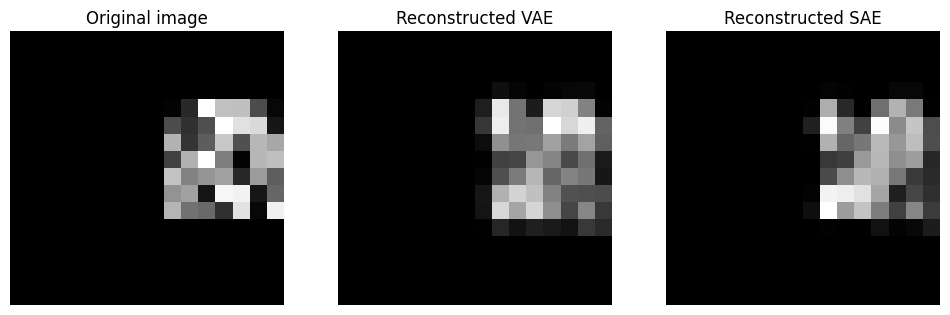

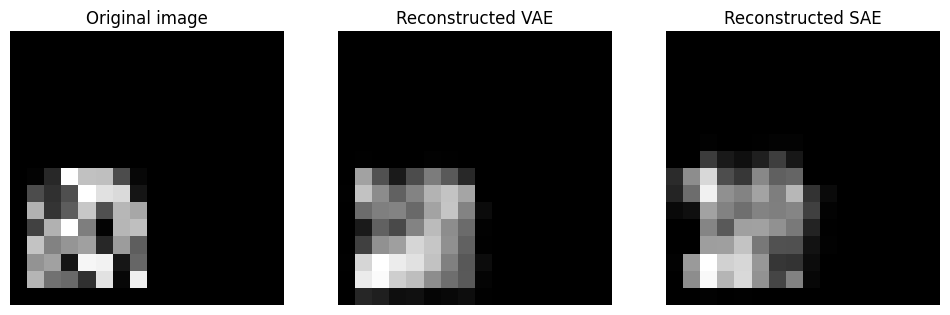

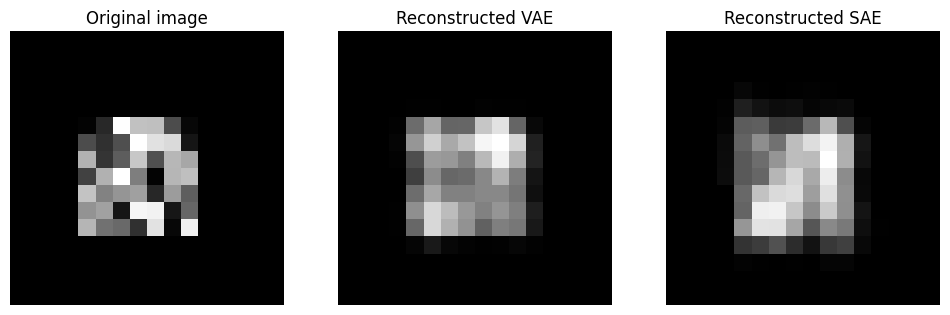

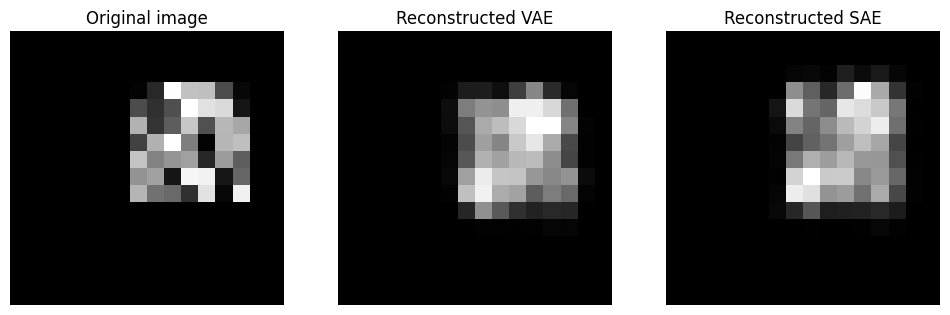

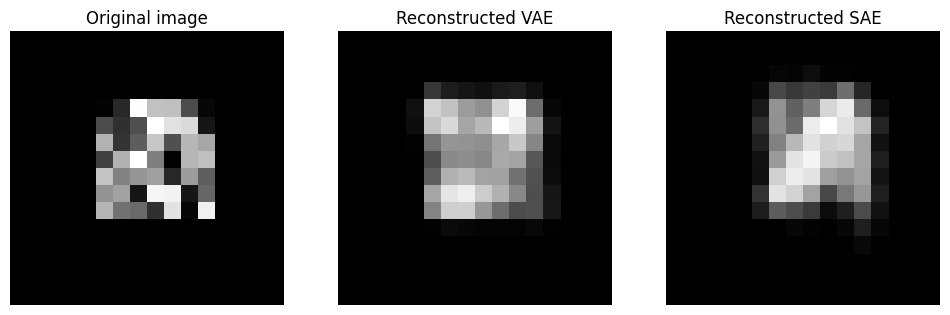

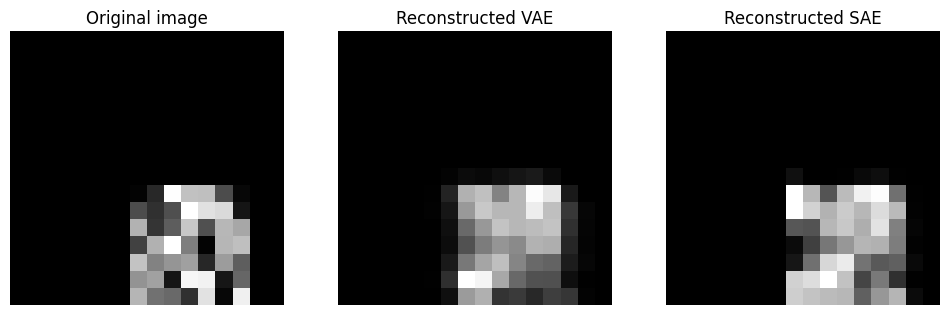

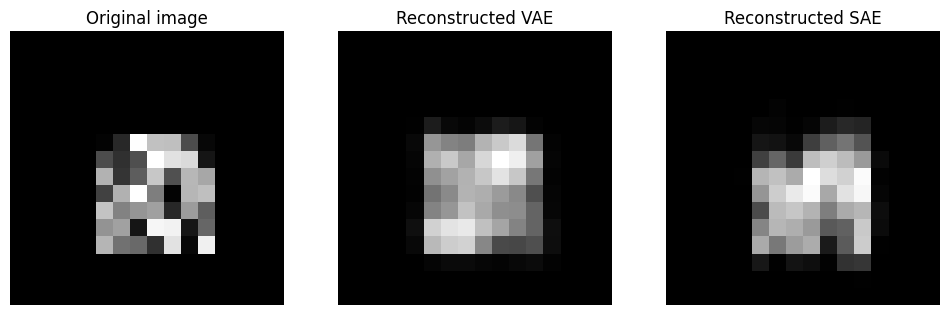

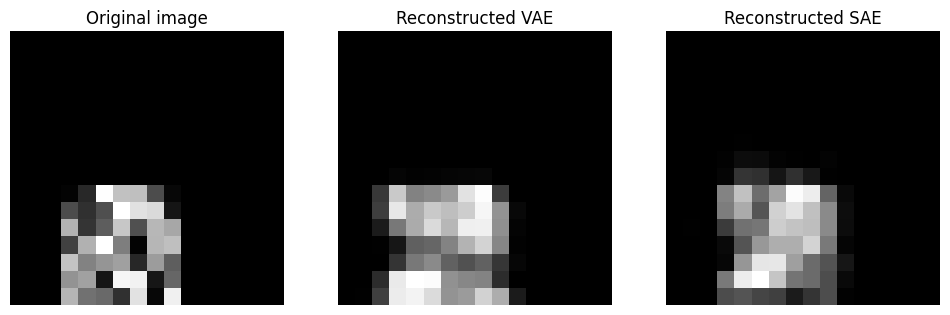

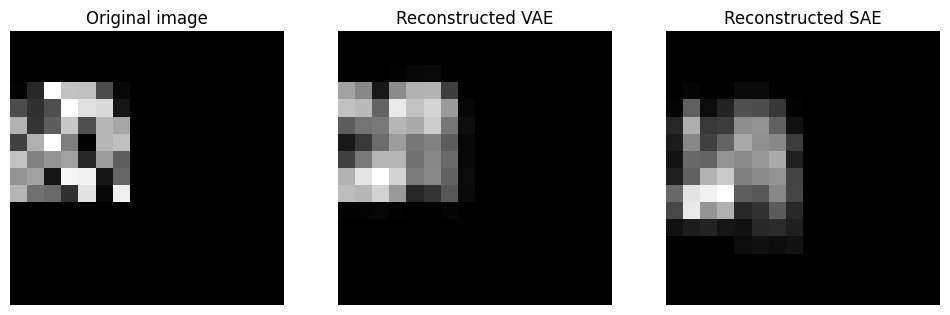

In [14]:
# Visualize the reconstruction of the test_dataset.

vae.eval()
sae.eval()

dataloader = dataloader_testing
bs = dataloader.batch_size

for data in dataloader:
    data = data.view(bs, image_vector_dim)
    
    data=data.to(DEVICE)

    data_vae, mean, variance, lat_vae = vae(data)
    data_sae, lat_sae                 = sae(data)
    
    data = data.view(bs, image_size[0], image_size[1])
    data_vae = data_vae.view(bs, image_size[0], image_size[1])
    data_sae = data_sae.view(bs, image_size[0], image_size[1])

    
    for i in range(bs):
        im0 = data[i]
        im0_np = im0.cpu().detach().numpy()
        im1 = data_vae[i]
        im1_np = im1.cpu().detach().numpy()
        im2 = data_sae[i]
        im2_np = im2.cpu().detach().numpy()
        
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.imshow(im0_np, cmap='gray')
        plt.axis('off')
        plt.title('Original image')
        plt.subplot(1,3,2)
        plt.imshow(im1_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed VAE')
        plt.subplot(1,3,3)
        plt.imshow(im2_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed SAE')
        
        plt.show()
        



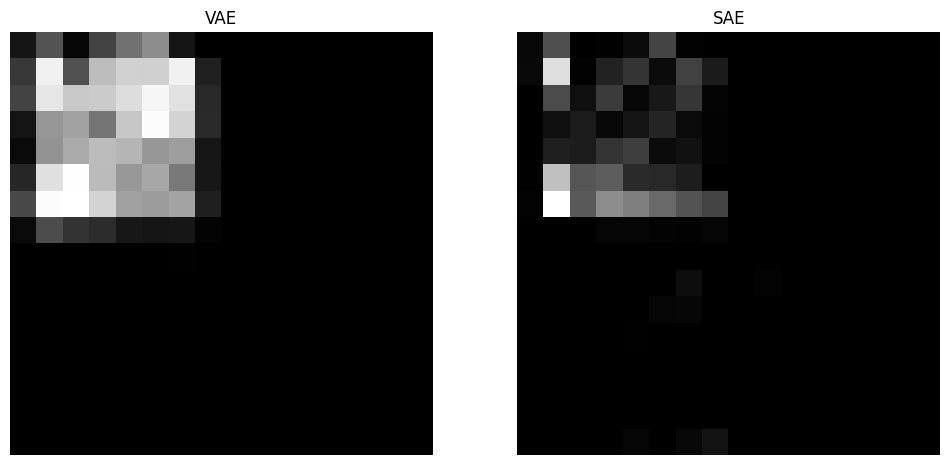

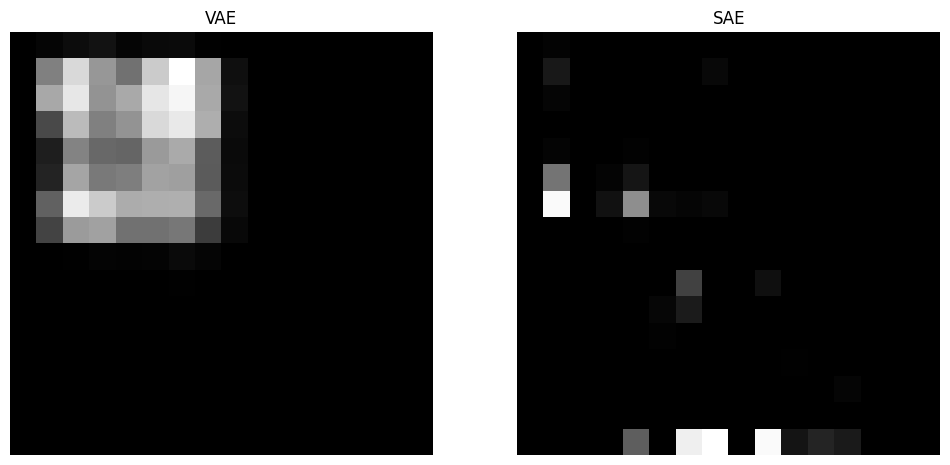

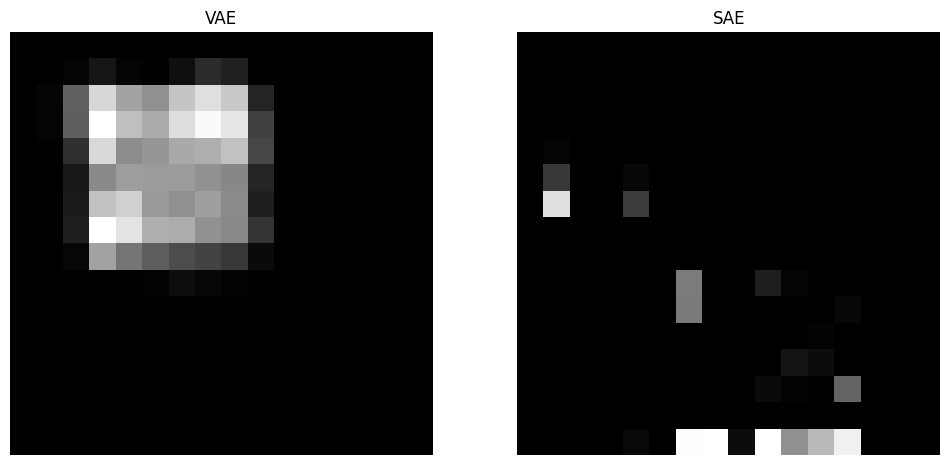

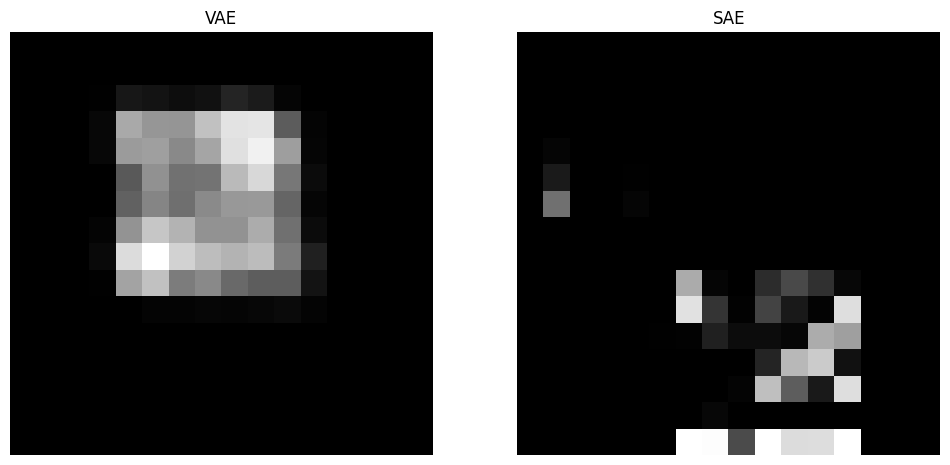

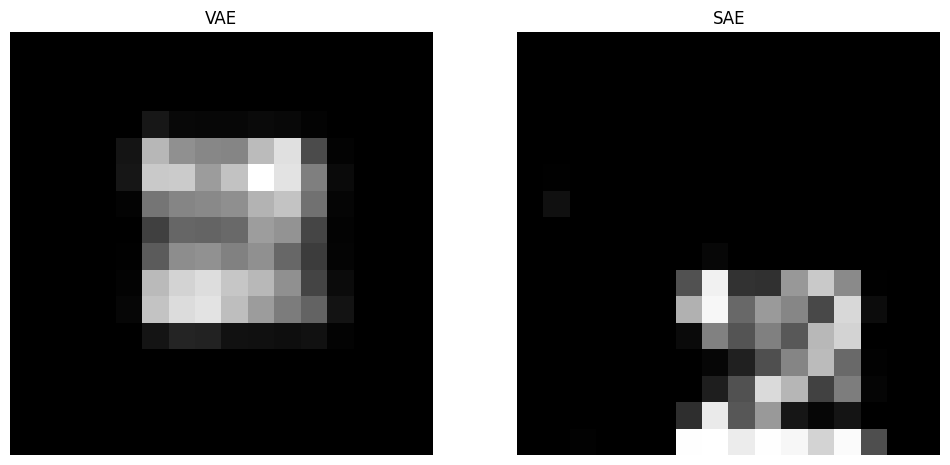

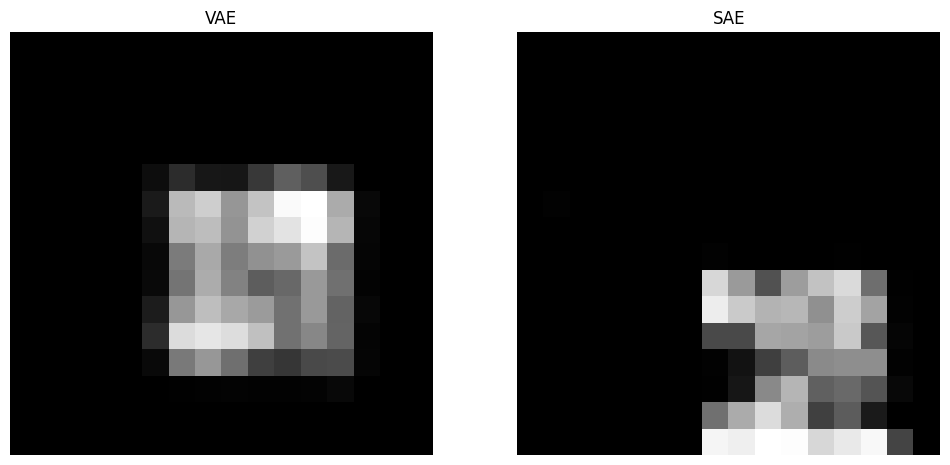

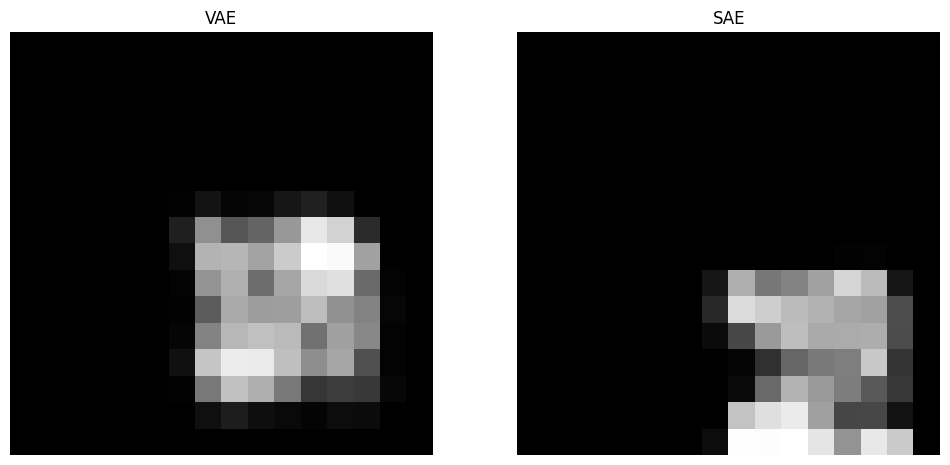

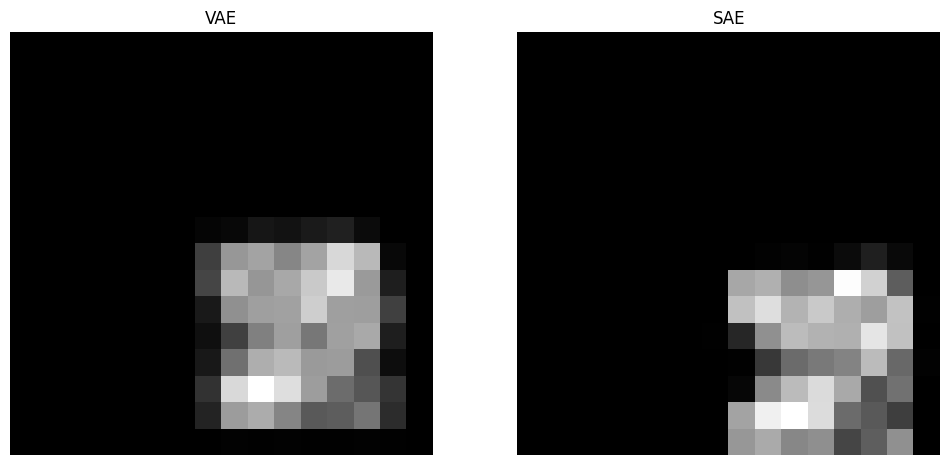

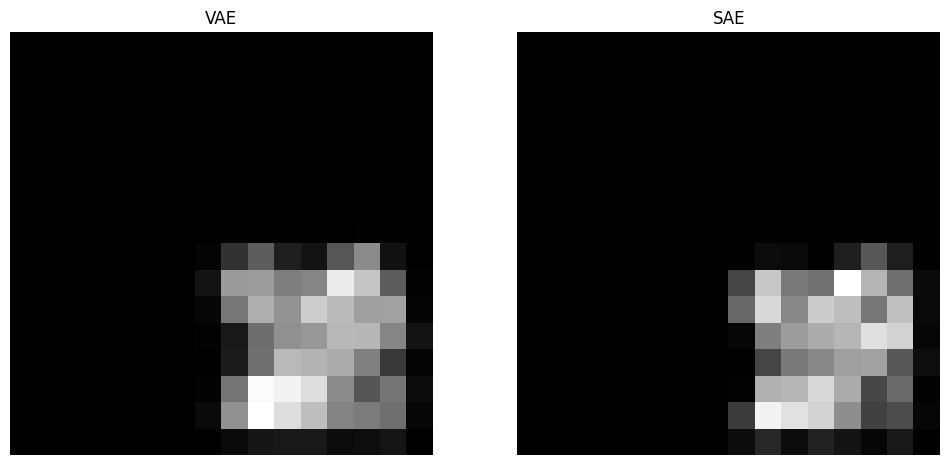

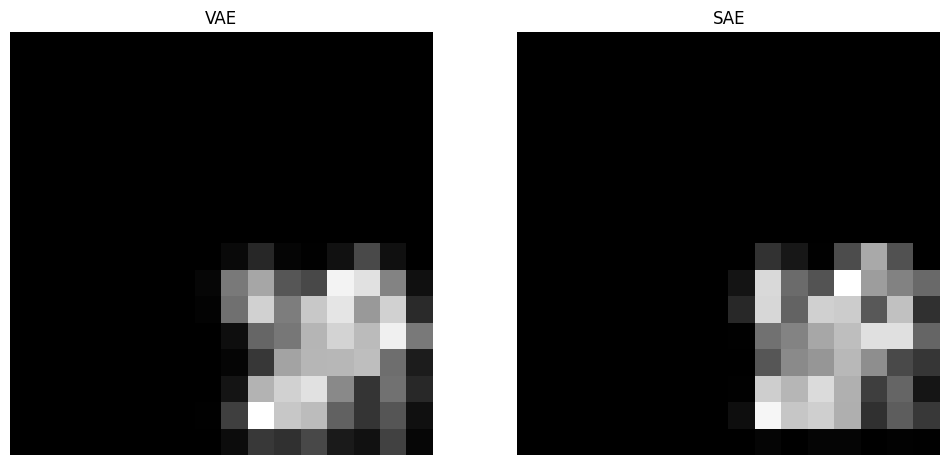

In [15]:
# Use both autoencoders to find the latent representation of objects in upper left and bottom right corners. Do a linear interpolation and visualize
# the decoder reconstruction output.

np.set_printoptions(suppress=True, floatmode='fixed')

n_points = 10

def linear_tensor_interpolation(p, n_points):
    start, end = p[0], p[1]
    pi = torch.stack([(1 - t) * start + t * end for t in torch.linspace(0, 1, n_points)])

    return pi

batch_tl = next(iter(dataloader_tl));
batch_tl = batch_tl.view(dataloader_tl.batch_size, image_vector_dim);
batch_tl = batch_tl.to(DEVICE);

batch_br = next(iter(dataloader_br));
batch_br = batch_br.view(dataloader_br.batch_size, image_vector_dim);
batch_br = batch_br.to(DEVICE);

batch_vae_tl, mean_tl, variance_tl, lat_vae_tl = vae(batch_tl);
batch_vae_br, mean_br, variance_br, lat_vae_br = vae(batch_br);

batch_sae_tl, lat_sae_tl = sae(batch_tl);
batch_sae_br, lat_sae_br = sae(batch_br);

vae_decoder = vae.get_decoder()
sae_decoder = sae.get_decoder()

im_vae = vae_decoder(linear_tensor_interpolation((lat_vae_tl, lat_vae_br), n_points));
im_vae = im_vae.view(n_points, image_size[0], image_size[1])

im_sae = sae_decoder(linear_tensor_interpolation((lat_sae_tl, lat_sae_br), n_points));
im_sae = im_sae.view(n_points, image_size[0], image_size[1])


for x in range(n_points):
    imv = im_vae[x]
    imv = imv.cpu().detach().numpy()

    ims = im_sae[x]
    ims = ims.cpu().detach().numpy()
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.imshow(imv, cmap='gray')
    plt.axis('off')
    plt.title('VAE')
    
    plt.subplot(1,2,2)
    plt.imshow(ims, cmap='gray')
    plt.axis('off')
    plt.title('SAE')
    


